# Introduction to Python for quantitative finance.


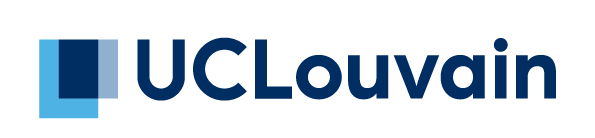



*Author* : Ubeydullah Ozcan (ozcanubey@outlook.com)

## Course 4 - Efficient frontier

### Efficient frontier

***Defintion*** : In modern portfolio theory, the efficient frontier (or portfolio frontier) is an investment portfolio which occupies the "efficient" parts of the risk–return spectrum. Formally, it is the set of portfolios which satisfy the condition that no other portfolio exists with a higher expected return but with the same standard deviation of return (i.e., the risk)





The graph below is the representation in term of risk-return of portfolios and for individual portfolios. The idea behind the efficient frontier is that it is impossible to reach this frontier by investing in indivual assets. 

The efficient frontier is build by calculate a set of $\mu_p$ and $\sigma_p$ for a set of $\gamma$. Let's see how does it work in Python.

### Code

####  1- Needed packages

In [5]:
from os import name
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import math

In [20]:
assets = ['AAPL', 'NVDA', "AMZN"]
pf_data = pd.DataFrame()
for x in assets:
    pf_data[x] = yf.download(x, start  = '2020-1-1', end = '2023-1-1')["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [21]:
log_returns = np.log(pf_data/pf_data.shift(1)).dropna()
log_returns.head()

,AAPL,NVDA,AMZN
Date,,,
2020-01-03,-0.009770,-0.016135,-0.012213
2020-01-06,0.007937,0.004185,0.014776
2020-01-07,-0.004714,0.012034,0.002089
2020-01-08,0.015958,0.001874,-0.007839
2020-01-09,0.021018,0.010923,0.004788


In [64]:
Nsim = 50000
n = len(assets)
w = np.zeros((Nsim, n))
portfolio_returns = []
portfolio_volatilities = []
sharpe_ratio = []
rf = 0.05

for i in np.arange(Nsim):
    weights = np.array(np.random.random(n))
    weights = weights/np.sum(weights)
    portfolio_returns.append(np.sum(weights * log_returns.mean()) * 250)
    portfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * 250, weights))))
    sharpe_ratio.append((portfolio_returns[i] - np.array(rf))/portfolio_volatilities[i])
    w[i,:] = weights

portfolios = pd.DataFrame({assets[0] : w[:,0], assets[1] : w[:,1], assets[2] : w[:,2],
                           'Return': portfolio_returns, 'Volatility':portfolio_volatilities, 
                          'sharpe_ratio' : sharpe_ratio})

In [65]:
portfolios.head()

,AAPL,NVDA,AMZN,Return,Volatility,sharpe_ratio
0,0.347079,0.324535,0.328386,0.145457,0.388785,0.245527
1,0.279481,0.132865,0.587653,0.066185,0.365064,0.044336
2,0.493955,0.316229,0.189817,0.175274,0.388343,0.322587
3,0.014824,0.310173,0.675004,0.066890,0.403656,0.041843
4,0.548816,0.270143,0.181042,0.171999,0.380993,0.320213


In [66]:
max(portfolios["sharpe_ratio"])

0.44314977727851995

In [67]:
index = portfolios["sharpe_ratio"].idxmax()
result = pd.DataFrame(portfolios.iloc[index])
result.columns = ['Result']
result

,Result
AAPL,0.278643
NVDA,0.720945
AMZN,0.000412
Return,0.263183
Volatility,0.481062
sharpe_ratio,0.443150


In [69]:
index2 = portfolios["Volatility"].idxmin()
result2 = pd.DataFrame(portfolios.iloc[index2])
result2.columns = ['Result']
result2

,Result
AAPL,0.608526
NVDA,0.000060
AMZN,0.391414
Return,0.094694
Volatility,0.344564
sharpe_ratio,0.129712


In [68]:
vol_maxsr = result.at["Volatility", "Result"]
ret_maxsr = result.at["Return", "Result"]

In [70]:
vol_minvol = result2.at["Volatility", "Result"]
ret_minvol = result2.at["Return", "Result"]

In [71]:
x2 = [0, float(vol_maxsr)]
y2 = [rf, float(ret_maxsr)]
slope, intercept = np.polyfit(x2,y2,1)
print(slope)

0.44314977727851984


In [72]:
range = np.arange(0, 0.8, 0.001)
rangey = slope * range + intercept

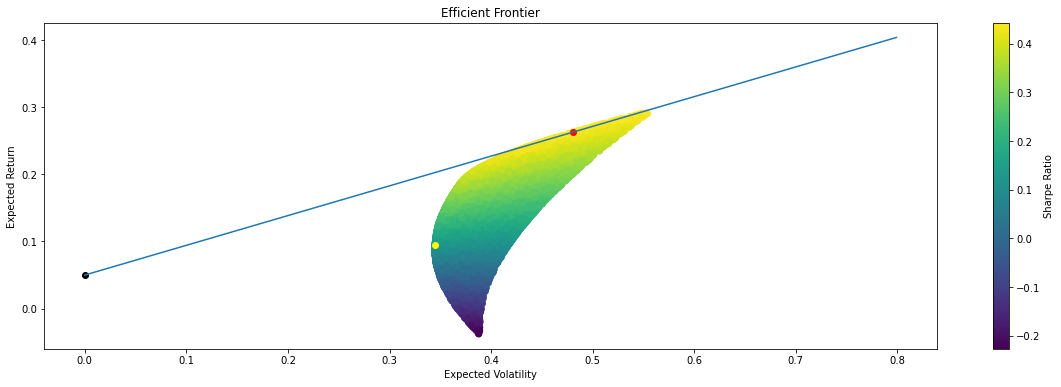

In [73]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,6))
plt.scatter(x = portfolios["Volatility"], y = portfolios["Return"], c = portfolios["sharpe_ratio"])
plt.xlabel("Expected Volatility")
plt.ylabel("Expected Return")
plt.colorbar(label = 'Sharpe Ratio')
plt.scatter(vol_maxsr, ret_maxsr, c = "red")
plt.scatter(vol_minvol, ret_minvol, c = "yellow")
plt.scatter(0, rf, c = "black")
plt.plot(range, rangey)
plt.title("Efficient Frontier");

### More mathematical way to find the weights that maximise the sharpe-ratio

Here is the optimization program to apply in order to find the weights that maximize the sharpe-ratio.

$$\underset{w}{minimize} \: \: \: w^T \Sigma w$$ 
$$\text{subject to} \: \: \: \mu * w \geq r_{min} $$
$$ w \geq 0 $$
$$ 1^T w = 1 $$

which is equivalent to,

$$\underset{w}{minimize} \: \: \: - SR(w)$$ 
$$ w \geq 0 $$
$$ 1^T w = 1 $$

In [34]:
from scipy.optimize import minimize

def negSR(w):
    w = np.array(w)
    R = np.sum(w * log_returns.mean()) * 250
    V = np.sqrt(np.dot(w.T,np.dot(log_returns.cov() * 250, w)))
    SR = (R - rf)/V
    return -1*SR

def check(w):
    return np.sum(w) - 1

w0 = [0.25, 0.25, 0.25]
bounds = ((0,1),(0,1),(0,1))
constraints = ({'type':'eq', 'fun':check})
w_opt = minimize(negSR, w0, method = "SLSQP", bounds = bounds, constraints = constraints)

In [35]:
w_opt.x

array([0.26187976, 0.73812024, 0.        ])

In [36]:
portfolios.iloc[index]

AAPL            0.303411
NVDA            0.695632
AMZN            0.000957
Return          0.260193
Volatility      0.474715
sharpe_ratio    0.442777
Name: 2143, dtype: float64

In [37]:
w_opt

     fun: -0.44335587316418523
     jac: array([-0.10293559, -0.10302331,  0.33124036])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.26187976, 0.73812024, 0.        ])

In [38]:
print("The maximum value of sharpe-ratio is", -w_opt.fun)

The maximum value of sharpe-ratio is 0.44335587316418523


In [39]:
print("The weights that maximize the sharpe ratio are as follow : ",w_opt.x[0].round(3), 
      "for", assets[0]," ",w_opt.x[1].round(3), " for ",  assets[1], " and ", w_opt.x[2].round(3), " for ", assets[2])

The weights that maximize the sharpe ratio are as follow :  0.262 for AAPL   0.738  for  NVDA  and  0.0  for  AMZN


### Optimal portfolio given a risk budget (For you information, not mandatory)
Given a risk budget, this leads to a unique portfolio.

If we want Loss > 25% with less than 1% probability, the portfolio X must obey : 
$$\mu_x + \sigma_x \Phi^{-1}(0.01) \geq -25\% \rightarrow \mu_x \geq -25\% + \sigma_x \Phi^{-1}(0.99) $$ 

In [37]:
from scipy.stats import norm
from scipy.optimize import fsolve

def intersection(sigma_int):
    return (-0.25 + sigma_int * norm.ppf(0.99)) - (slope * sigma_int + RF)

In [38]:
sigma_intersection = fsolve(intersection, 0)
sigma_intersection

array([0.24470495])

In [39]:
mu_intersection = -0.25 + sigma_intersection * norm.ppf(0.99)
mu_intersection

array([0.31926885])

In [40]:
x_cml = np.arange(0,1,0.05)
y_cml = (x_cml * slope) + RF

sigma_i = np.arange(0.01, 1, 0.01)
mu_i = -0.25 + sigma_i * norm.ppf(0.99)

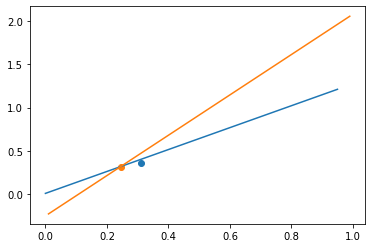

In [41]:
fig, ax = plt.subplots()

ax.plot(x_cml, y_cml)
ax.plot(sigma_i, mu_i)
ax.scatter(sigma_msr, mu_msr)
ax.scatter(sigma_intersection, mu_intersection)


plt.show()

***Figure***: All portfolios on the left of the orange line makes the constraint. Only one is optimal, at
the intersection with the EF (little leverage). Being more tolerant moves the dotted line to the
right.

In [42]:
def opt_ptf_risk_budg(gamma):
    ww = (np.linalg.inv(cov) @ (mu - RF))/gamma
    mu2 = (ww.T @ mu) + RF*(1 - ww.T @ np.full((len(mu), 1), 1))
    return float(mu2) - float(mu_intersection)

In [43]:
opt_gamma = fsolve(opt_ptf_risk_budg, 1)
print("the optimal gamma is ", opt_gamma)

the optimal gamma is  [4.17141802]


In [44]:
print("the optimal portfolio under risk budget is ", (np.linalg.inv(cov) @ (mu - RF))/opt_gamma)

the optimal portfolio under risk budget is  [[ 0.57483814]
 [-0.1696679 ]
 [ 0.47341699]]
